# D212 PA 1 code - Doug Haunsperger

## Data Preparation

### Do initial package import and data read

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

df = pd.read_csv('medical_clean.csv')
#view first 5 rows
df.head(5)

CaseOrder Customer_id                           Interaction  \
0          1     C412403  8cd49b13-f45a-4b47-a2bd-173ffa932c2f   
1          2     Z919181  d2450b70-0337-4406-bdbb-bc1037f1734c   
2          3     F995323  a2057123-abf5-4a2c-abad-8ffe33512562   
3          4     A879973  1dec528d-eb34-4079-adce-0d7a40e82205   
4          5     C544523  5885f56b-d6da-43a3-8760-83583af94266   

                                UID          City State        County    Zip  \
0  3a83ddb66e2ae73798bdf1d705dc0932           Eva    AL        Morgan  35621   
1  176354c5eef714957d486009feabf195      Marianna    FL       Jackson  32446   
2  e19a0fa00aeda885b8a436757e889bc9   Sioux Falls    SD     Minnehaha  57110   
3  cd17d7b6d152cb6f23957346d11c3f07  New Richland    MN        Waseca  56072   
4  d2f0425877b10ed6bb381f3e2579424a    West Point    VA  King William  23181   

        Lat       Lng  ...  TotalCharge Additional_charges Item1 Item2  Item3  \
0  34.34960 -86.72508  ...  3726.702860       17939.403420     3     3      2   
1  30.84513 -85.22907  ...  4193.190458       17612.998120     3     4      3   
2  43.54321 -96.63772  ...  2434.234222       17505.192460     2     4      4   
3  43.89744 -93.51479  ...  2127.830423       12993.437350     3     5      5   
4  37.59894 -76.88958  ...  2113.073274        3716.525786     2     1      3   

   Item4  Item5 Item6 Item7 Item8  
0      2      4     3     3     4  
1      4      4     4     3     3  
2      4      3     4     3     3  
3      3      4     5     5     5  
4      3      5     3     4     3  

[5 rows x 50 columns]

### Treating Outliers
I will use the same treatment methodologies I did with the data in D208. In this case, I choose to retain all outliers except 0 values for `Population`.

#### Population
Population is reasonable to have a long-tail, right-skew distribution. However, zero values are not reasonable. They would also interfere with doing a log transformation if necessary.

In [2]:
df[(df.Population == 0)].shape

(109, 50)

Removing `Population == 0` outliers from the data set and move them to a separate data frame

In [3]:
pop_outliers = df[(df.Population == 0)]
df.drop(df[(df.Population == 0)].index, inplace=True)
df.shape

# Do a log transformation on Population and Income to produce more normally distributed values
df['Population'] = np.log(df.Population)
df['Income'] = np.log(df.Income)

df.rename(columns={'Population': 'logPop', 'Income': 'logIncome'}, inplace=True)
df.head()

CaseOrder Customer_id                           Interaction  \
0          1     C412403  8cd49b13-f45a-4b47-a2bd-173ffa932c2f   
1          2     Z919181  d2450b70-0337-4406-bdbb-bc1037f1734c   
2          3     F995323  a2057123-abf5-4a2c-abad-8ffe33512562   
3          4     A879973  1dec528d-eb34-4079-adce-0d7a40e82205   
4          5     C544523  5885f56b-d6da-43a3-8760-83583af94266   

                                UID          City State        County    Zip  \
0  3a83ddb66e2ae73798bdf1d705dc0932           Eva    AL        Morgan  35621   
1  176354c5eef714957d486009feabf195      Marianna    FL       Jackson  32446   
2  e19a0fa00aeda885b8a436757e889bc9   Sioux Falls    SD     Minnehaha  57110   
3  cd17d7b6d152cb6f23957346d11c3f07  New Richland    MN        Waseca  56072   
4  d2f0425877b10ed6bb381f3e2579424a    West Point    VA  King William  23181   

        Lat       Lng  ...  TotalCharge Additional_charges Item1 Item2  Item3  \
0  34.34960 -86.72508  ...  3726.702860       17939.403420     3     3      2   
1  30.84513 -85.22907  ...  4193.190458       17612.998120     3     4      3   
2  43.54321 -96.63772  ...  2434.234222       17505.192460     2     4      4   
3  43.89744 -93.51479  ...  2127.830423       12993.437350     3     5      5   
4  37.59894 -76.88958  ...  2113.073274        3716.525786     2     1      3   

   Item4  Item5 Item6 Item7 Item8  
0      2      4     3     3     4  
1      4      4     4     3     3  
2      4      3     4     3     3  
3      3      4     5     5     5  
4      3      5     3     4     3  

[5 rows x 50 columns]

### Selecting variables to answer research question

For possible explanatory variables, I am casting a wide net, looking at demographic info as well as reported medical conditions. I then normalize the variables so they have similar variances.

In [4]:
# Only work with the 5 continuous quantitative variables, plus the 2 discrete with a large variation (Age, Population)
quant_cols_7 = ['logPop', 'Age', 'logIncome', 'VitD_levels', 'Initial_days', 'TotalCharge', 'Additional_charges']
X = df[quant_cols_7].copy(deep=True)

# Normalize the variables
scaler = StandardScaler()
dfq_std = scaler.fit_transform(X)

X_scale = pd.DataFrame(dfq_std, columns=X.columns)

In [5]:
X_scale.head()

logPop       Age  logIncome  VitD_levels  Initial_days  TotalCharge  \
0  0.027391 -0.026922   1.289472     0.582558     -0.907810    -0.728126   
1  0.747619 -0.123788   0.516713     0.482882     -0.735102    -0.514131   
2  0.970442 -0.026922  -0.967031     0.045328     -1.128782    -1.321029   
3 -0.139461  1.183899   0.311131    -0.688510     -1.244988    -1.461588   
4  0.340119 -1.528340  -4.076729    -0.261182     -1.262475    -1.468357   

   Additional_charges  
0            0.763455  
1            0.713558  
2            0.697078  
3            0.007379  
4           -1.410756

### Output clean and scaled data set

In [6]:
X_scale.to_csv('clean_medical_data.csv', index=False)

### Perform principal component analysis for dimensionality reduction

In [7]:

# Perform PCA for dimensionality reduction
pca = PCA()
pc = pca.fit_transform(dfq_std)

# Start with 7 principal components since there are 7 variables
pc_cols = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
pc_df = pd.DataFrame(pc, columns = pc_cols)

# Show explained variance per PC
print(pca.explained_variance_ratio_)

# Show loadings on each PC
loadings = pd.DataFrame(pca.components_, columns = pc_cols, index = X.columns)
print(loadings)

[0.28467266 0.24466857 0.14446136 0.1427491  0.1411959  0.04057936
 0.00167305]
                         PC1       PC2       PC3       PC4       PC5  \
logPop              0.019302  0.088946 -0.013514 -0.001753  0.700725   
Age                -0.024496  0.701227 -0.014074  0.016304 -0.093891   
logIncome          -0.152723 -0.011103 -0.705311  0.691712 -0.002173   
VitD_levels        -0.976272 -0.005772  0.001685 -0.214561  0.015377   
Initial_days        0.149964  0.005309 -0.708558 -0.689365 -0.009403   
TotalCharge         0.010373  0.706749  0.009901 -0.001603  0.031395   
Additional_charges  0.000086  0.026281  0.000544 -0.001599 -0.706296   

                         PC6       PC7  
logPop              0.701849  0.089011  
Age                -0.083588  0.701010  
logIncome          -0.000921 -0.024879  
VitD_levels         0.014206 -0.019563  
Initial_days       -0.010672 -0.000795  
TotalCharge        -0.031484 -0.705918  
Additional_charges  0.706480 -0.036596  


#### Calculate eigenvalues

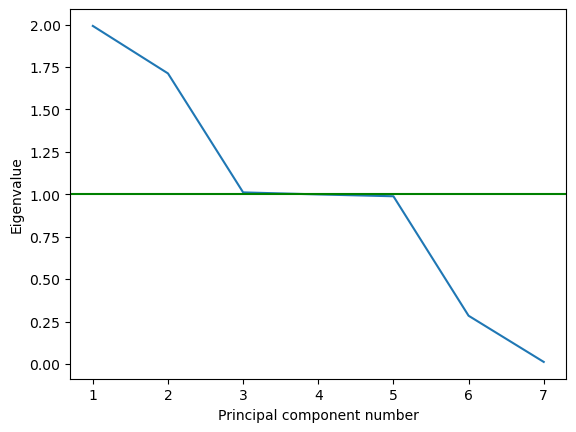

[1.9927086364280442, 1.712679998023505, 1.0112295204945034, 0.9992436824882592, 0.988371306480794, 0.28405551423735226, 0.011711341847541001]
[0.28467266 0.52934123 0.67380259 0.81655169 0.95774759 0.99832695
 1.        ]


In [16]:
# Code reference: Getting Started with PCA (Middleton, n.d.)

cov_matrix = np.dot(dfq_std.T, dfq_std) / dfq_std.shape[0]
eigenvals = [np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)) for eigenvector in pca.components_]
pcnums = np.array([1,2,3,4,5,6,7])

plt.plot(pcnums,eigenvals)
plt.xlabel('Principal component number')
plt.ylabel('Eigenvalue')
plt.axhline (y=1, color='green')
plt.show()

print(eigenvals)
print(pca.explained_variance_ratio_.cumsum())

#### Plot explained variance per principal component

[0.28467266234686345, 0.244668571146215, 0.14446136007064334, 0.14274909749832274, 0.1411959009258277, 0.040579359176764605, 0.0016730488353630002]
[0.28467266 0.52934123 0.67380259 0.81655169 0.95774759 0.99832695
 1.        ]


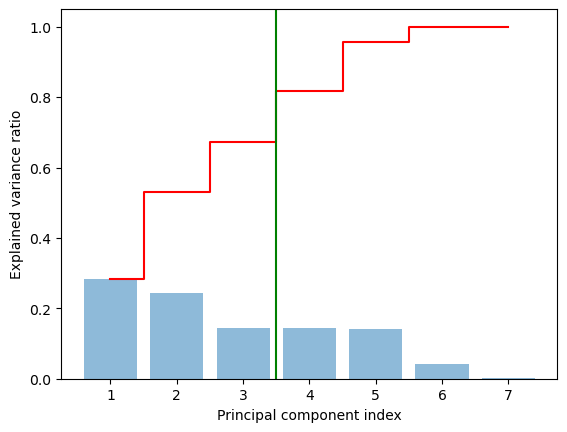

In [18]:
tot = sum(eigenvals)
var_exp = [(i / tot) for i in sorted(eigenvals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(var_exp)
print(cum_var_exp)

plt.bar(range(1,len(eigenvals)+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1,len(eigenvals)+1), cum_var_exp, where='mid',
         label='Cumulative explained variance',
         color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axvline(x=3.5, color='green')
plt.show()

### Transform dataset using chosen PCs

In [10]:
# Keeping 2 principal components

pca2 = PCA(n_components=2)
pca2.fit(dfq_std)
X_pc = pca2.transform(dfq_std)

# Keeping 3 principal components

pca3 = PCA(n_components=3)
pca3.fit(dfq_std)
X_pc3 = pca3.transform(dfq_std)

## Data Analysis

### Determine K-means with different cluster sizes & Evaluate

For n_clusters = 2 The average silhouette_score is : 0.4859741213303005
For n_clusters = 3 The average silhouette_score is : 0.4566291129399494
For n_clusters = 4 The average silhouette_score is : 0.5056664504805605
For n_clusters = 5 The average silhouette_score is : 0.46992741608505284
For n_clusters = 6 The average silhouette_score is : 0.44741929720845297
For n_clusters = 7 The average silhouette_score is : 0.4195003208951479


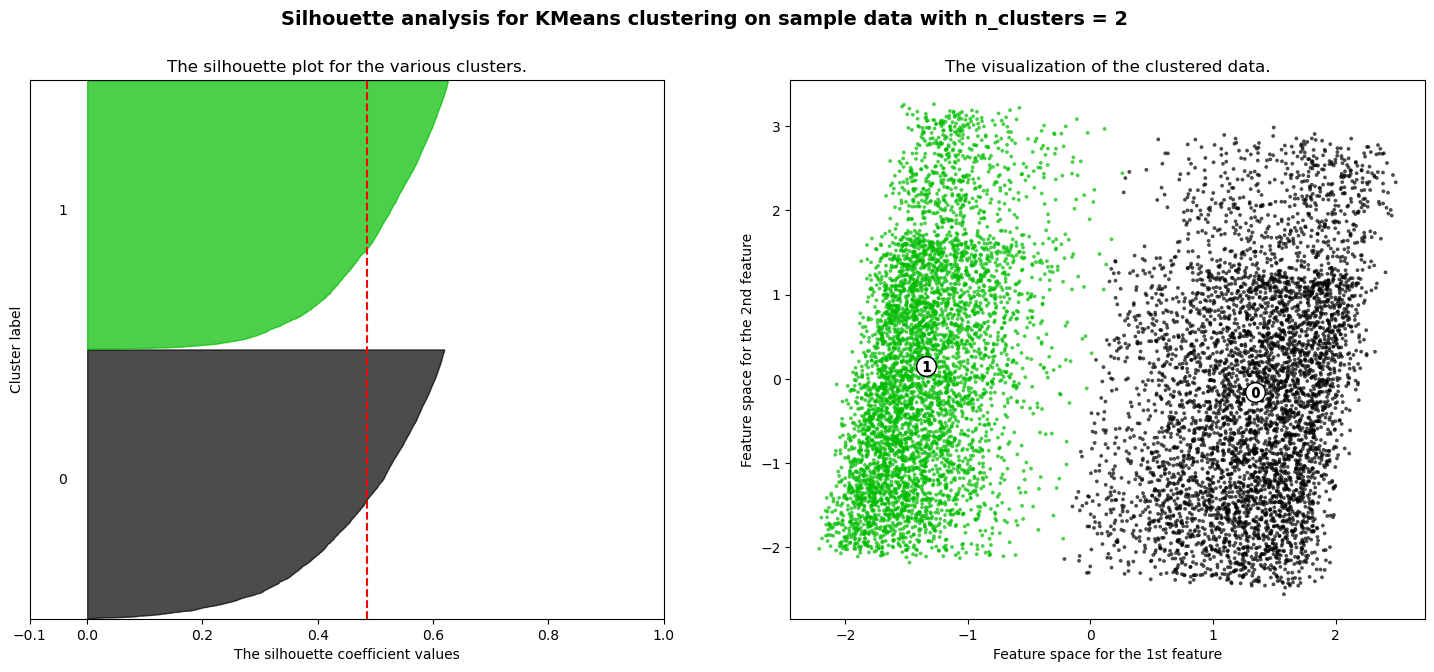

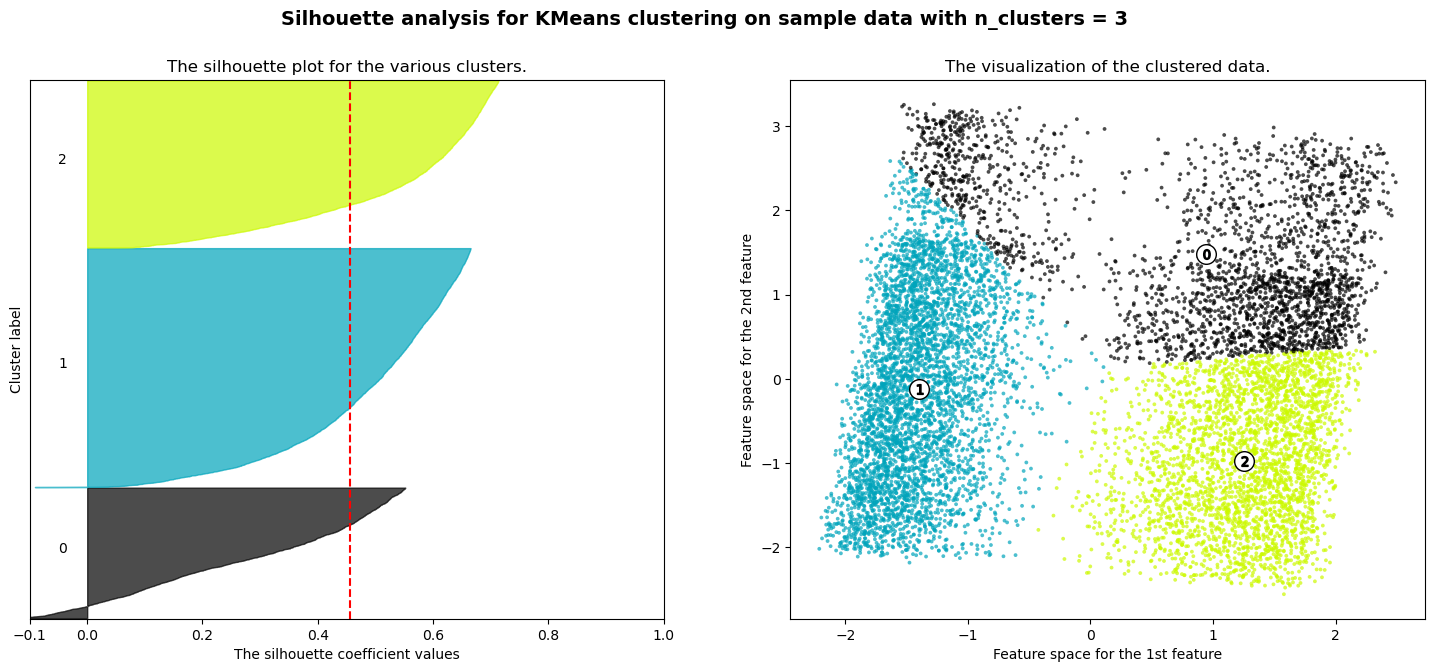

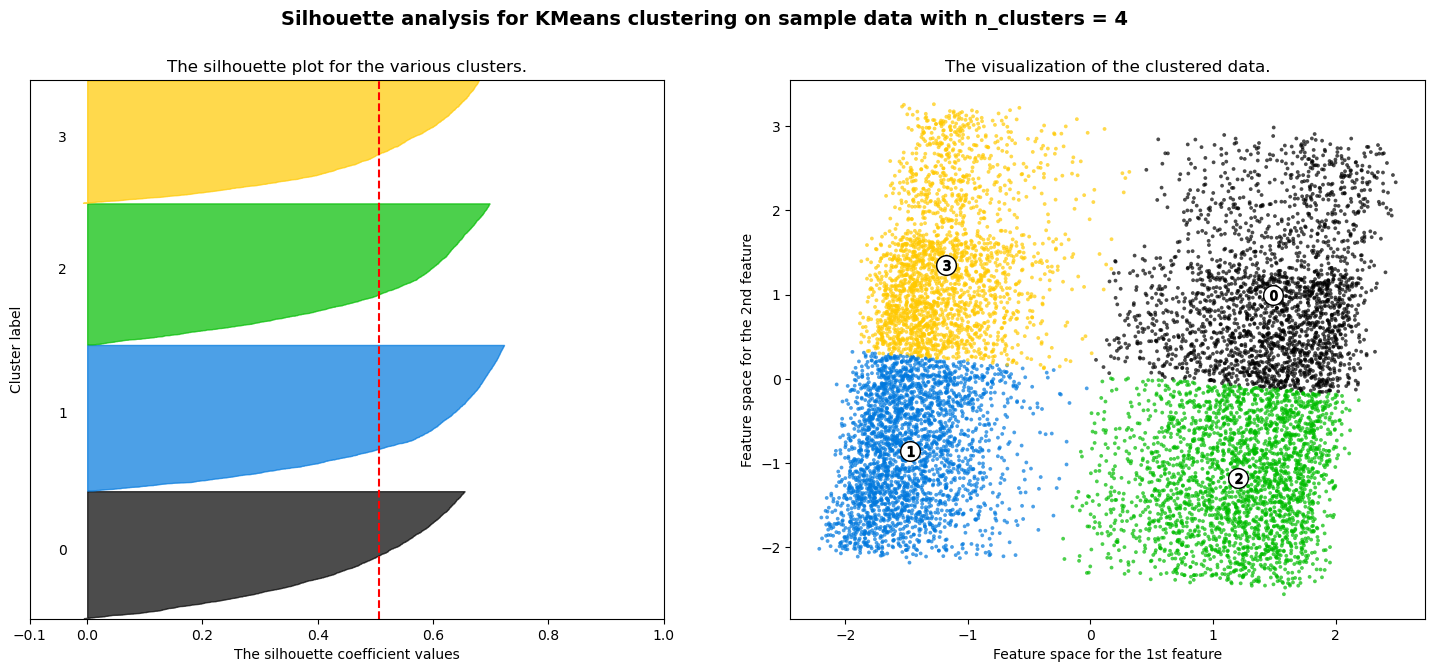

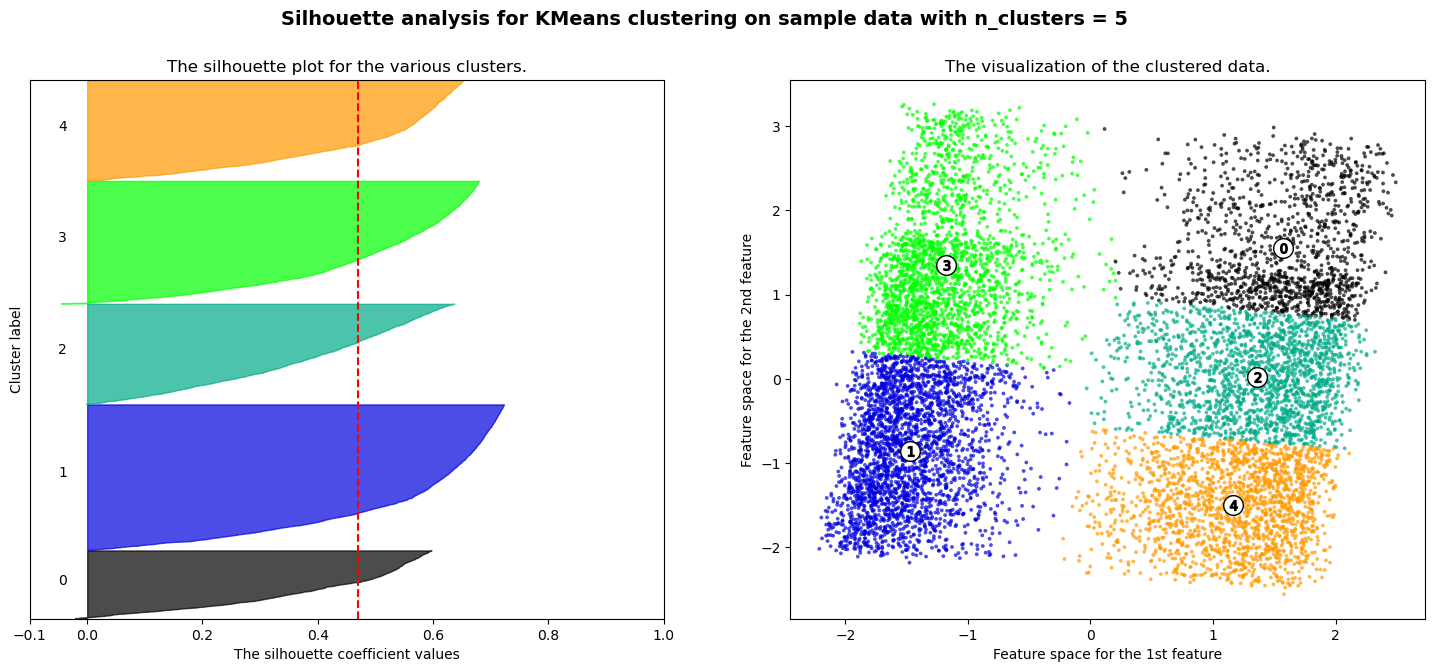

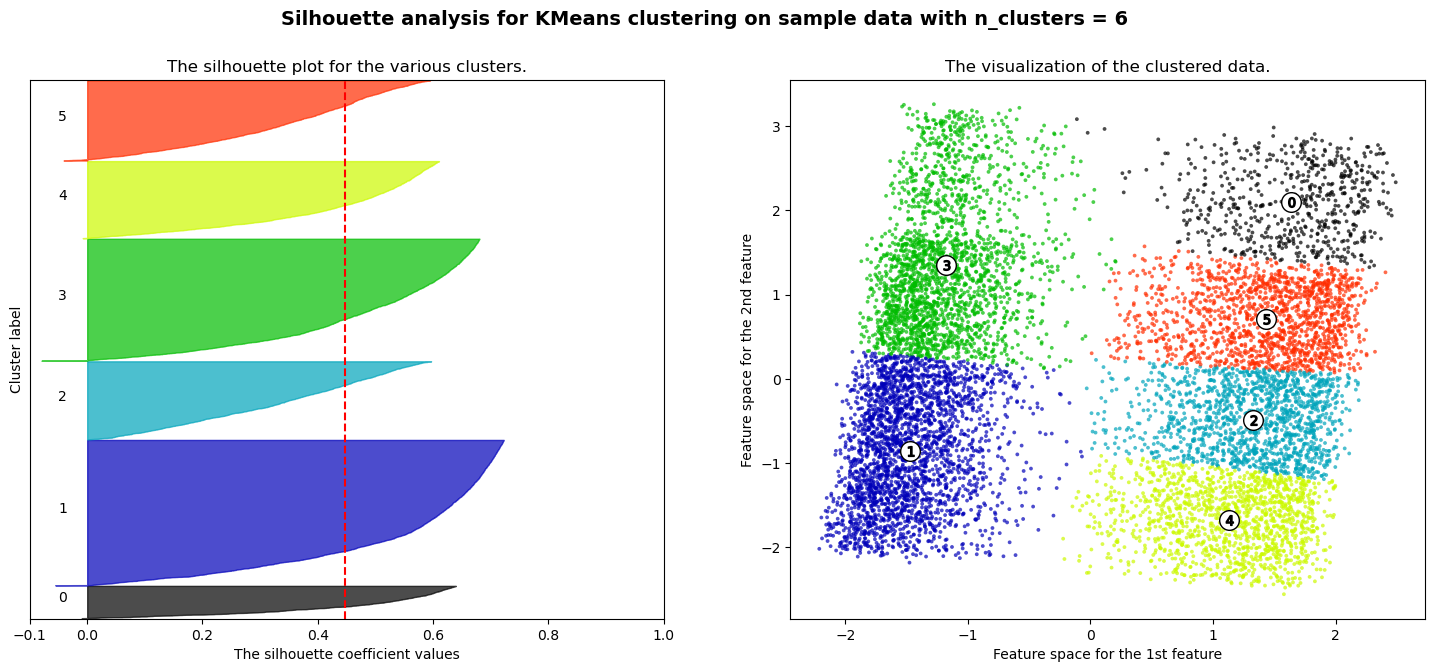

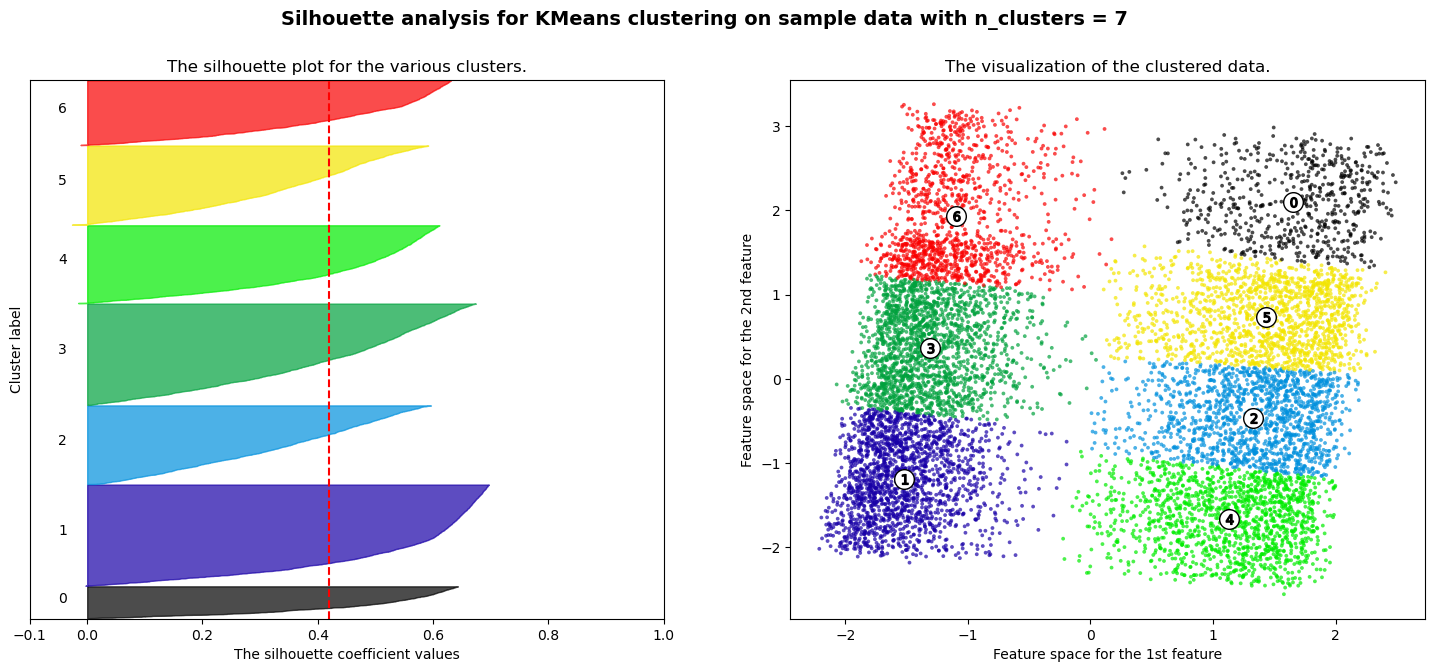

In [11]:
# Code ref - inertia: (Bruce, Bruce, & Gedeck, 2020)
# Code ref - silhouette graphs: (scikit-learn.org, n.d.)

# First try with 2 PCs - easier to visualize clusters, even if less than 60% of variance is explained
inertia = []
for n_clusters in range(2,8):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but we will cut off below -0.1 to emphasize positive values
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pc) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = km.fit_predict(X_pc)
    inertia.append(km.inertia_ / n_clusters)
    
    silhouette_avg = silhouette_score(X_pc, labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pc, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pc[:, 0], X_pc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



### Plot Inertias for each cluster grouping

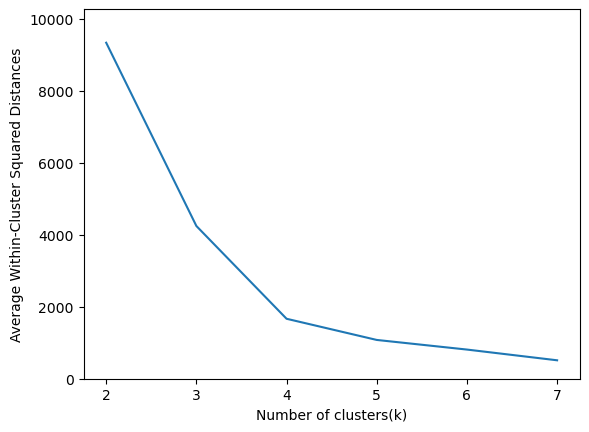

In [12]:
inertias = pd.DataFrame({'n_clusters': range(2, 8), 'inertia': inertia}) 
ax = inertias.plot(x='n_clusters', y='inertia') 
plt.xlabel('Number of clusters(k)') 
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max())) 
ax.legend().set_visible(False)

plt.show()

### Difficult to see visually if 2 or 4 clusters is superior. Add a 3rd PC to see if it improves 

For n_clusters = 2 The average silhouette_score is : 0.25618452026755867
For n_clusters = 3 The average silhouette_score is : 0.20788231072909788
For n_clusters = 4 The average silhouette_score is : 0.20052079391388553
For n_clusters = 5 The average silhouette_score is : 0.18613146582757037
For n_clusters = 6 The average silhouette_score is : 0.1751693445066116
For n_clusters = 7 The average silhouette_score is : 0.15885437998605742


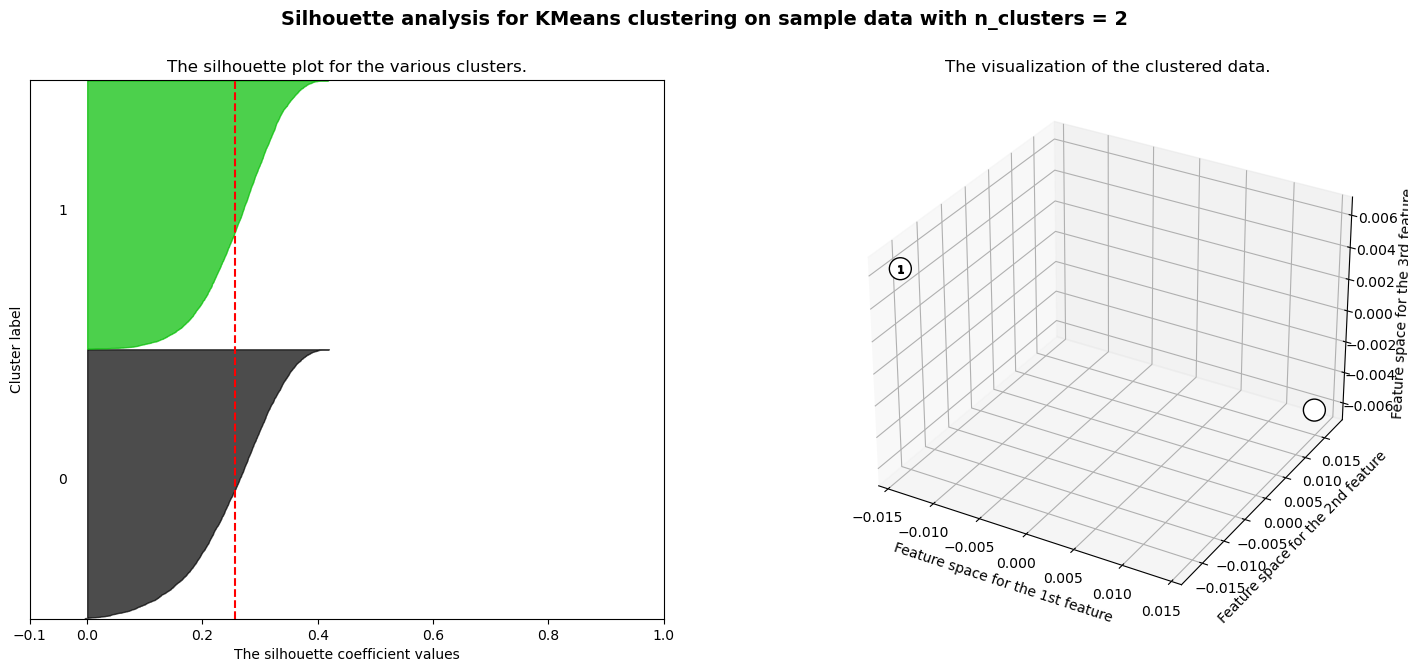

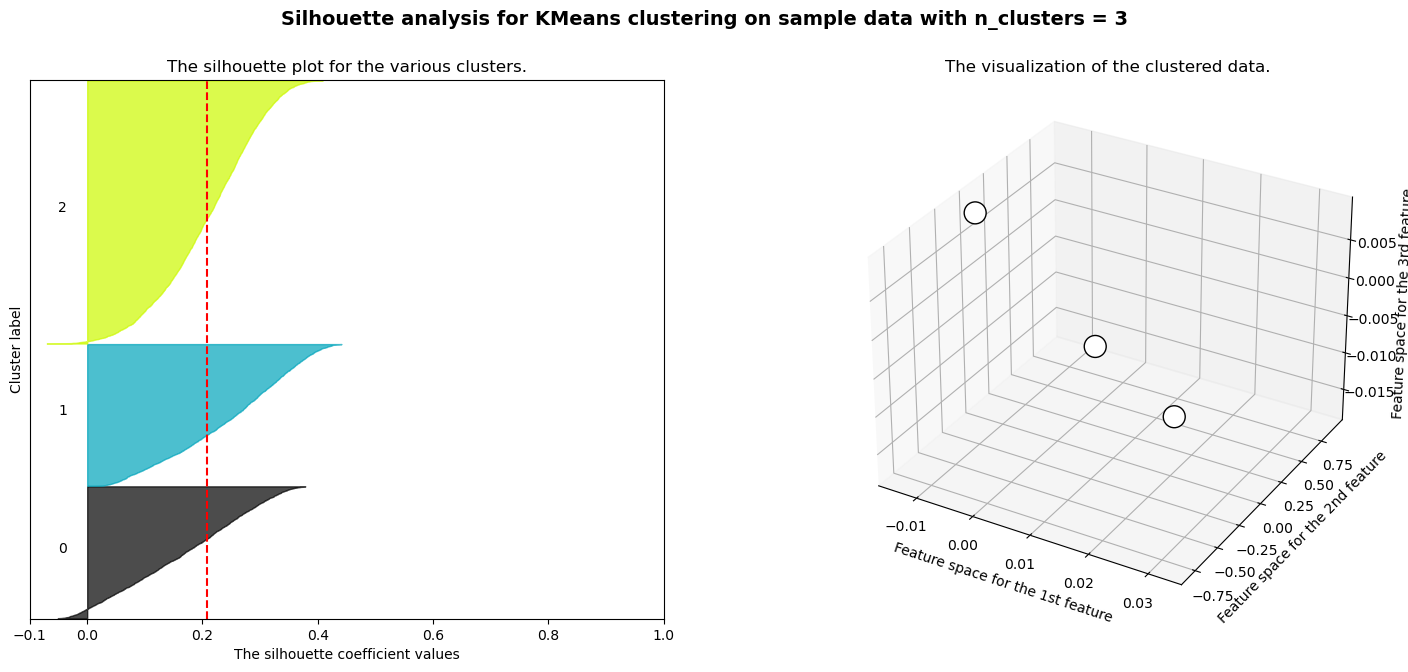

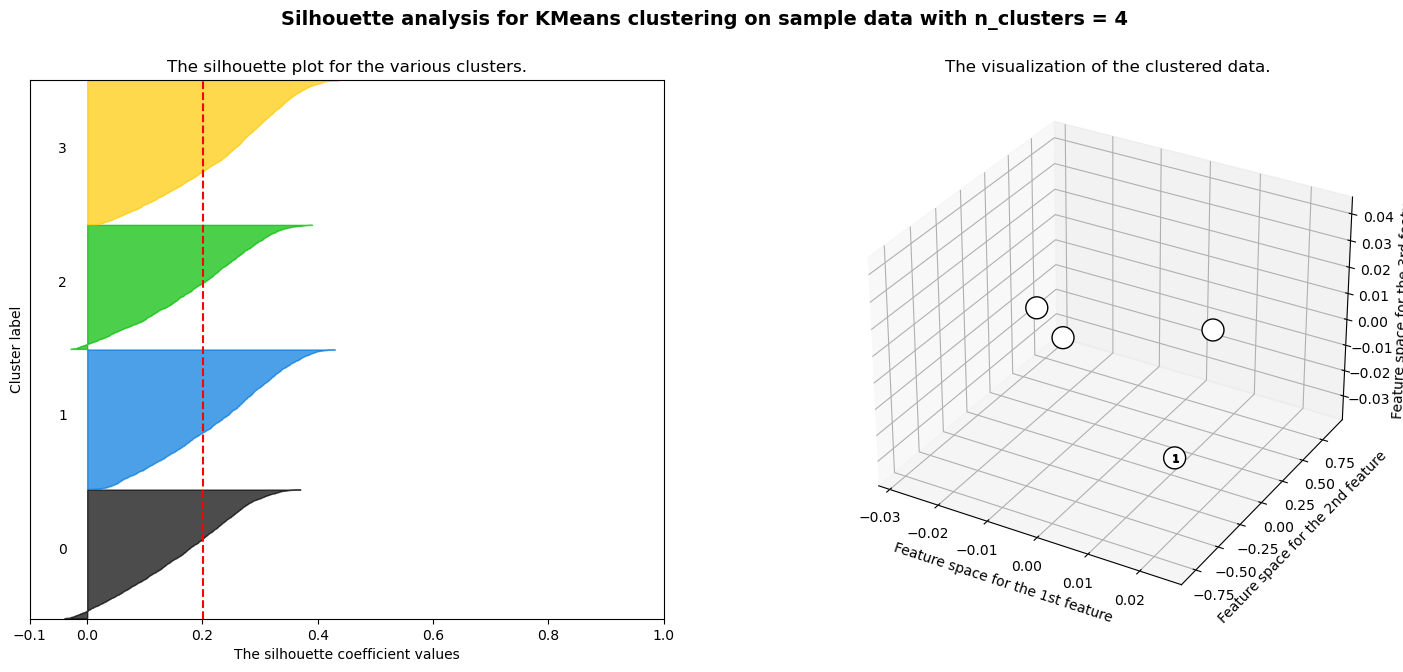

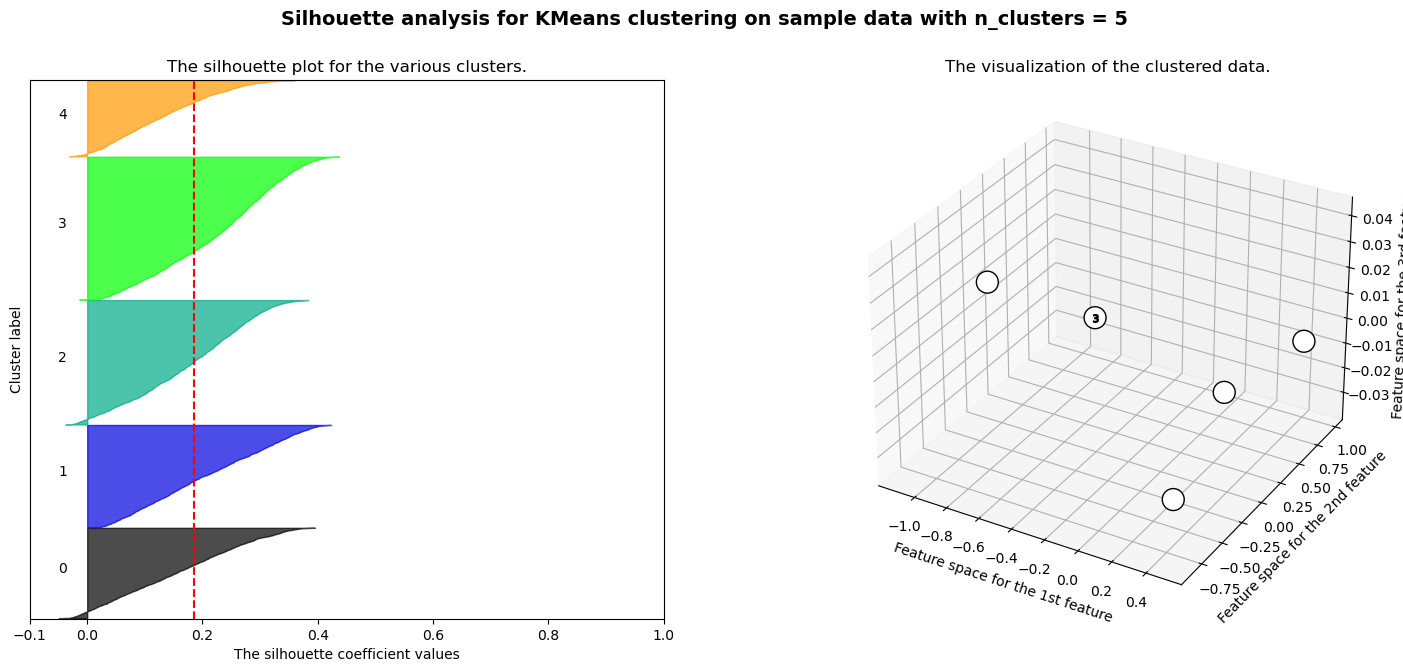

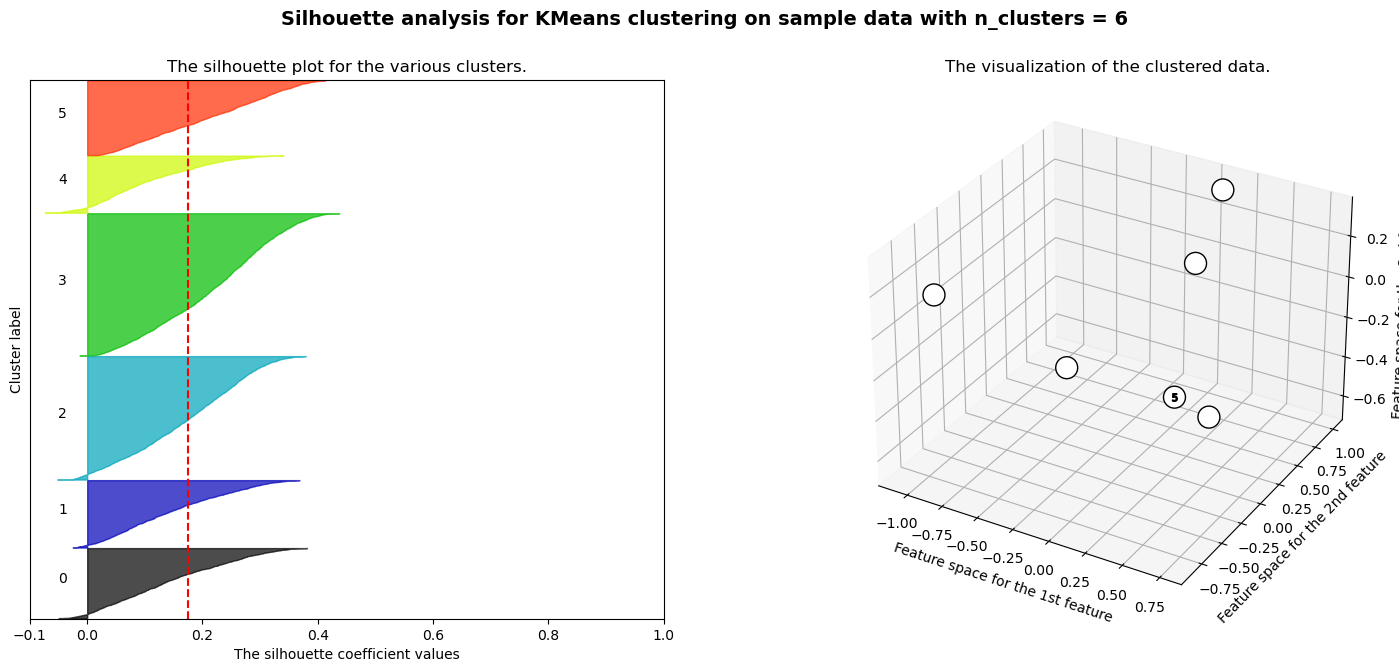

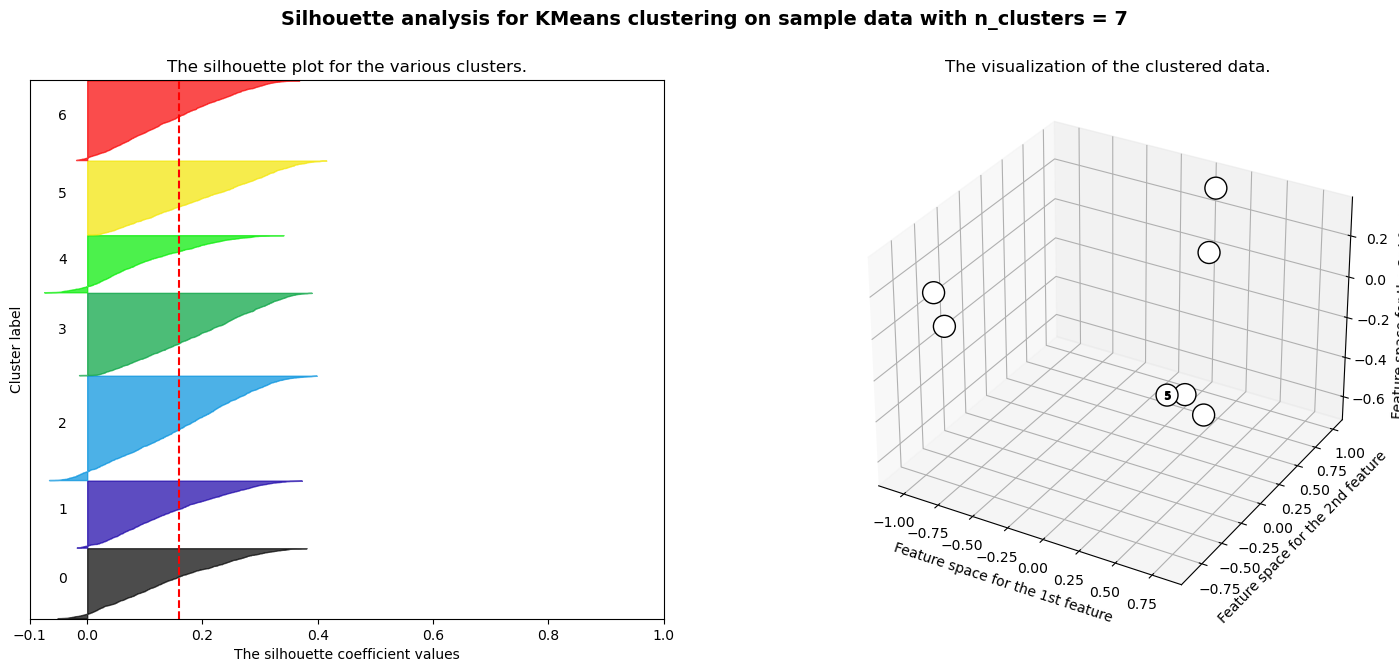

In [21]:

inertia = []
for n_clusters in range(2,8):
    # Create a subplot with 1 row and 2 columns
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2,projection='3d')
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but we will cut off below -0.1 to emphasize positive values
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scale) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scale)
    inertia.append(km.inertia_ / n_clusters)
    
    silhouette_avg = silhouette_score(X_scale, labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scale, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
#    ax2.scatter(
#        X_scale[:, 0], X_scale[:, 1], X_scale[:, 2], marker=".", s=30, lw=0, alpha=0.3, c=colors, edgecolor="k"
#    )

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        marker="o",
        c="white",
        alpha=1,
        s=250,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], marker="$%d$" % i, alpha=1, s=30, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.set_zlabel("Feature space for the 3rd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



### Plot Inertias for each cluster grouping

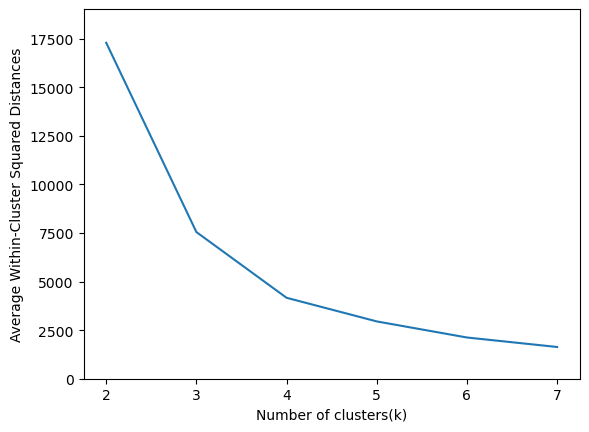

In [14]:
inertias = pd.DataFrame({'n_clusters': range(2, 8), 'inertia': inertia}) 
ax = inertias.plot(x='n_clusters', y='inertia') 
plt.xlabel('Number of clusters(k)') 
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max())) 
ax.legend().set_visible(False)

plt.show()